In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import functools
import pandas as pd
from typing import Union
import tableprint as tab

plt.rc('font', **{'size' : 18})

In [ ]:
# train_set si test_set sunt matrice care contin pe prima coloana clasa, 
# ca o cifra de la 0 la 9
# imaginea cifrei este pastrata incepand de pe coloana 1 pana la terminare
# Decupati in train_x doar imaginile iar in train_y doar clasa,
# si faceti acelasi lucru si pentru test_x si test_y

train_x = train_set[:,1:]
train_y = train_set[:,0]
test_x = test_set[:,1:]
test_y = test_set[:,0]

assert train_x.shape == (60000, 784)
assert train_y.shape == (60000,)
assert test_x.shape == (10000, 784)
assert test_y.shape == (10000,)

In [ ]:
# Prin urmare, adaugam o coloana cu 1 pentru orice x
def add_ones_column(x: np.ndarray) -> np.ndarray:
    """
    Returns a matrix with first column filled with 1 and the other columns being x's columns.
    """
    return np.hstack((np.ones((x.shape[0],1)),x))

#hstack -> lipesc orizontal 2 matrici
#o linie de 1 pentru antrenarea si folosirea termenului liber in theta

def normalize(x: np.ndarray) -> np.ndarray:
    """
    Normalization means division by 255.
    
    Args:
        x: feature matrix, shape m * n. It will not be changed by this code.
    
    Returns:
        matrix with scaled values between 0 and 1, of same shape
    """
    #returnez valorile intre 0 si 1 pentru eficienta PC
    return x/255

In [ ]:
# Numarul de clase (10 cifre in setul de date)
k = 10

# Adaugam la features coloana de 1-uri
train_x_all_ext = add_ones_column(normalize(train_x))
test_x_all_ext = add_ones_column(normalize(test_x))

assert train_x_all_ext.shape == (60000, 785)
assert test_x_all_ext.shape == (10000, 785)
assert np.all(train_x_all_ext[:, 0] == 1)
assert np.all(test_x_all_ext[:, 0] == 1)
assert np.all(train_x_all_ext <= 1)
assert np.all(test_x_all_ext <= 1)
assert np.all(train_x_all_ext >= 0)
assert np.all(test_x_all_ext >= 0)

In [ ]:
def one_hot(val: int, classes: int) -> np.ndarray:
    """
    Realizeaza 'one-hot encoding', conversia unui intreg la un array binar,
    care are 1 doar pe pozitia specificata de val
    
    Args:
        val: clasa ce trebuie encodata, un intreg intre {0, 1, ... K-1}
        classes: numarul de clase K
        
    Returns:
        un array de zerouri de lungime K, unde doar pe pozitia val avem o valoare 1
    """
    assert 0 <= val < classes
    #formez un array 2d cu o linie classes coloane, cu valori 0
    result:np.ndarray = np.zeros((1,classes), dtype = int)
    result[0,val] = 1
    assert result.shape == (1, classes)
    return result

assert np.all(one_hot(7, k) == np.array([[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]]))
assert np.all(one_hot(3, k) == np.array([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]]))

#transformam vectorul de etichete 1D in forma one hot,
#lucru esential pentru comp. intre etichete si predictii,
#in acest fel putand calcula functia de cost.
#unim fiecare coloana pentru a forma o matrice
train_y_all : np.ndarray = np.concatenate([one_hot(int(i), k) for i in train_y])
test_y_all : np.ndarray = np.concatenate([one_hot(int(i), k) for i in test_y])
assert train_y_all.shape == (60000, 10)
assert test_y_all.shape == (10000, 10)
#verificarea valorilor binare
assert np.all((train_y_all != 0) == (train_y_all == 1))

In [ ]:
#vector de scoruri (valorile lui theta sunt pe coloana a cate 10)
#returneaza m linii a cate k coloane(k clase)
#pe fiecare linie sunt insiruite scorurile pentru fiecare inmultire cu theta 
def prod(x: np.ndarray, theta: np.ndarray) -> np.ndarray:
    """
    Product between X of shape (m x n) and theta of shape (n x k)
    
    Args:
        x: feature-urile, dimensiune m x n
        theta: parametrii, de dimensiune n x k
        
    Returns:
        produsul lor de dimensiune m x k
    """
    #vom returna produsul matricial dintre X si theta
    #fiecare linie a lui X se va inmultii cu fiecare coloana din theta
    #produs matricial = inmultirie intre fiecare linie X coloana theta
    return (x @ theta)

m, n = train_x_all_ext.shape #linii si coloane a lui X
np.random.seed(11) #valori random pentru theta
theta = np.random.randn(n, k)
assert prod(train_x_all_ext, theta).shape == (m, k)

In [ ]:
#asigura ca functia pe ficare rand este 1
def softmax(x: np.ndarray, theta: np.ndarray) -> np.ndarray:
    """"
    Calculul functie softmax
    
    Args:
        x: feature-urile, dimensiune m x n
        theta: parametrii, de dimensiune n x k
        
    Returns:
        produsul lor de dimensiune m x k
    """
    assert x.shape[1] == theta.shape[0]
    #formez un vector de scoruri
    Z:np.ndarray = prod(x,theta)
    #scad pe fiecare rand valoarea maxima
    #broadcast -> retin sumele pe coloana (m,1)
    #folosit pentru a evita overflow (numere prea mari) -> asigur valori <=0
    #e^0 = 1 (valori intre 0 si 1)
    Z_stab = Z-np.max(Z, axis = 1, keepdims = True)
    #functie exponentiala, pastrez dim Z(numarator)
    #N = e^Z_stab pe fiecare elem
    #->toate  nr poz -> diferente mari
    #prin np.exp (fiecare element fiind e^elem) asigur valori intre 0 si 1
    N:np.ndarray = np.exp(Z_stab)
    #suma pe linie a fiecarui rand (numitor)
    #retine sumele pe coloana
    D:np.ndarray = N.sum(axis=1, keepdims = True)
    #finalizarea prin impartire(softmax)
    #s-a folosit broadcast pentru a putea impartii doua matrici de dim diferite
     #D este o coloana cu suma fiecarui rand ->broadcast-> vector cu o singura coloana
    #keepdims = true -> permite gandirea lui D ca fiind de dim N fara a crea copii ulterioare
    #(adauga virtual coloanele lipsa in timpul impartirii)
    #->D este responsabil pentru suma totala = 1 pe fiecare rand 
    return N/D

m, n = train_x_all_ext.shape
np.random.seed(11)
theta = np.random.randn(n, k)
#smax = train + prod + softmax
smax = softmax(train_x_all_ext, theta)
assert smax.shape == (m, k)
assert np.all((smax.sum(axis=1) - 1) < 1e-12)

In [ ]:
def cost(x: np.ndarray, y: np.ndarray, theta: np.ndarray, lmbda: float) -> float:
    """
    Costul include regularizarea
    
    Args:
        x: feature-urile, dimensiune m x n
        y: clasele, de dimensiune m x k
        theta: parametrii, de dimensiune n x k
        lmbda: parametrul de regularizare, scalar
        
    Returns:
        costul, ca scalar

    """
    # I CROSS ENTRY PLATFORM
    #formez vectorul de probabilitati - predictia
    A: np.ndarray = softmax(x,theta)
    #penalizarea 
    A_log: np.ndarray = np.log(A + 1e-10)
    #izolarea costului real
    cost_matrix: np.ndarray = y * A_log
    #costul mediu
    #folosim media pentru irelevanta marimii batch-ului
    #semnul minus pentru a avea valoare pozitiva
    cross_loss: float = -np.sum(cost_matrix)/m

    # II REGULARIZARE L2 - FROBENIUS (prevenirea supra-antrenarii)
    #se exclude bias-ul
    theta_reg : np.ndarray = theta[1:,:]
    #norma frobenius -> pastreaza greutatile mici pentru generalizare
    frobenius_norm_sq: float = np.sum(theta_reg**2)
    #penalizarea
    reg_term: float = (lmbda)/2 * frobenius_norm_sq
    # TOTAL COST
    total_cost: float = cross_loss + reg_term
    return total_cost

m, n = train_x_all_ext.shape
np.random.seed(11)
theta = np.random.randn(n, k)
assert (cost(train_x_all_ext, train_y_all, theta=theta, lmbda=0.2) - 804.384938) < 1e-6

In [ ]:
def deltas(x: np.ndarray, y: np.ndarray, theta: np.ndarray, lmbda: float) -> np.ndarray:
    """
    Calculeaza gradientul

    Args:
        x: feature-urile, dimensiune m x n
        y: clasele, de dimensiune m x k
        theta: parametrii, de dimensiune n x k
        lmbda: parametrul de regularizare, scalar
        
    Returns:
        matricea gradientilor, de dimensiunea lui theta (n x k)
    """
    m,n = x.shape
    A: np.ndarray = softmax(x,theta)
    #calcul eroare simpla -> trimite eroarea in negativ 
    delta: np.ndarray = A-y
    # x->90 -> propagarea erorii pe fiecare elem din imagine
    grad: np.ndarray = (x.T @ delta)/m #inmultirea fiecarui pixel cu eroarea fiecarei valori
    theta_copy: np.ndarray = theta.copy() #copie pentru calcul ulterior
    theta_copy[0,:] = 0
    grad_reg:np.ndarray = lmbda * theta_copy #mentinerea valorilor generalizate
    total_grad:np.ndarray = grad + grad_reg #gradienti finali 
    return total_grad

m, n = train_x_all_ext.shape
np.random.seed(11)
theta = np.random.randn(n, k) #valori random pentru theta
grad : np.ndarray = deltas(train_x_all_ext, train_y_all, theta=theta, lmbda=0.2) #calcul gradienti
assert grad.shape == (n, k)
assert (grad.sum() + 6.0286086) < 1e-6

# Acuratetea

In [ ]:
def calculate_accurracy(set_x : np.ndarray, set_y : np.ndarray, theta : np.ndarray) -> float:
    A:np.ndarray = softmax(set_x,theta) #predictii
    prediction_array: np.ndarray = np.argmax(A,axis=1) #index predictii
    true_array:np.ndarray = np.argmax(set_y,axis=1) #valoarea prezisa
    bool_array:np.ndarray = (prediction_array == true_array) #numar de valori prezise corect
    true_values: int = np.sum(bool_array) #suma valorilor prezise corect
    total_values:int = set_x.shape[0] #numar total valori
    accuracy: float = true_values/total_values #formula 
    return 100.0 * accuracy

## Antrenarea

In [ ]:
lmbda, alpha = 0.05, 0.65 # Learning rate, coeficientul de regularizare
m, n = train_x_all_ext.shape
np.random.seed(11)
theta = np.random.randn(n, k)

epochs = 300
values = []
accurracies = []
for i in range(epochs):
    grad:np.ndarray = deltas(train_x_all_ext,train_y_all,theta=theta,lmbda=lmbda) #calcularea gradientilor
    theta -= alpha * grad #modificari theta
    if i % 10 == 0: #la fiecare 10 epoci -> update
        values.append(cost(train_x_all_ext, train_y_all, theta, lmbda))
        accurracies.append(calculate_accurracy(test_x_all_ext, test_y_all, theta))
        print("epoch: ", i, "cost: ", values[-1], ' accuracy: ', accurracies[-1])
        lmbda *= 0.9
    
print("last costs: %g" % values[-1])

epoch:  0 cost:  194.3407381438446  accuracy:  11.940000000000001
epoch:  10 cost:  93.81788269357887  accuracy:  41.44
epoch:  20 cost:  49.13054492858501  accuracy:  59.919999999999995
epoch:  30 cost:  27.42488716166984  accuracy:  70.1
epoch:  40 cost:  16.206693369063352  accuracy:  76.55999999999999
epoch:  50 cost:  10.102164735641082  accuracy:  80.36
epoch:  60 cost:  6.625548733620425  accuracy:  83.3
epoch:  70 cost:  4.561883665265482  accuracy:  85.03
epoch:  80 cost:  3.2892055120605592  accuracy:  86.28
epoch:  90 cost:  2.475919071855923  accuracy:  87.28
epoch:  100 cost:  1.9386228646035604  accuracy:  88.01
epoch:  110 cost:  1.5723999210860642  accuracy:  88.39
epoch:  120 cost:  1.31533336314113  accuracy:  88.8
epoch:  130 cost:  1.129816514459429  accuracy:  89.1
epoch:  140 cost:  0.9923925228080539  accuracy:  89.21
epoch:  150 cost:  0.8880657845146891  accuracy:  89.42999999999999
epoch:  160 cost:  0.8070284662808471  accuracy:  89.59
epoch:  170 cost:  0.74

Afisam graficul pentru functia de cost si acuratete in urma antrenarii:

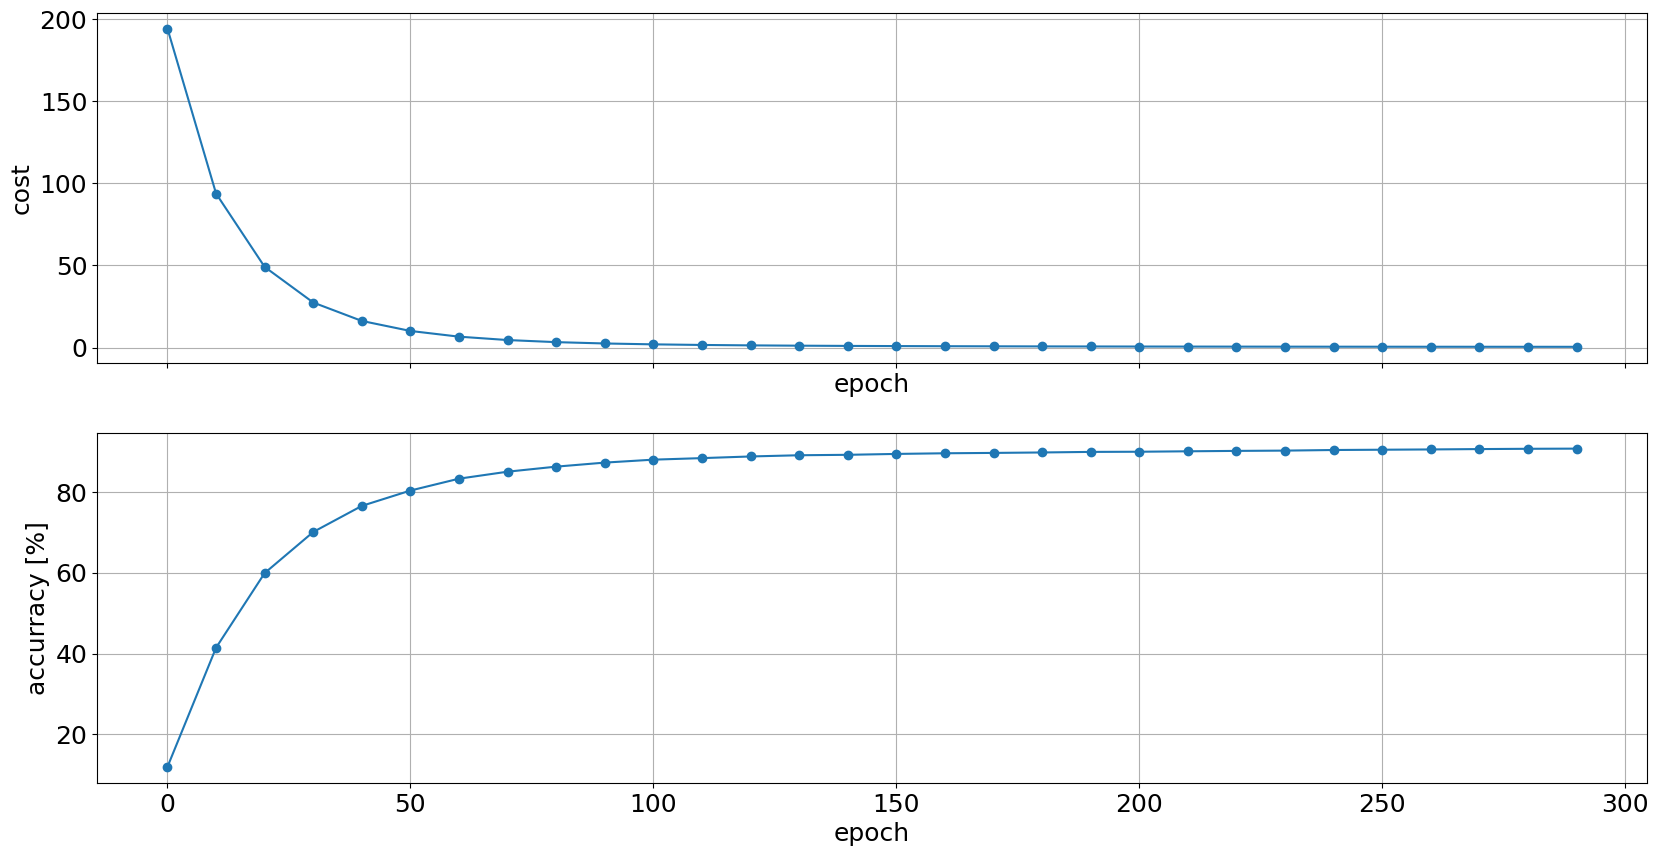

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(20, 10), sharex=True)
ax[0].plot([x * 10 for x in range(len(values))], values, 'o-')
ax[0].set_xlabel('epoch') ; ax[0].set_ylabel('cost')
ax[0].grid()
ax[1].plot([x * 10 for x in range(len(accurracies))], accurracies, 'o-')
ax[1].set_xlabel('epoch') ; ax[1].set_ylabel('accurracy [%]')
ax[1].grid()
plt.show()

Calculam acuratetea pentru setul de date:

In [ ]:
# Calculam acuratetea pentru setul de test
# Aceasta presupune sa numaram cate predictii se potrivesc cu realitatea si sa exprimam acest lucru procentual
pred:np.ndarray  = np.argmax(softmax(test_x_all_ext,theta),axis=1)
actual:np.ndarray = np.argmax(test_y_all,axis=1)
equalities:int = np.sum(pred == actual)
print("Test accuracy: %2.2f%%" % ( 100*(equalities/test_x_all_ext.shape[0])))

Test accuracy: 90.82%


Calculam matricea de confuzie (vom avea 10 linii si 10 coloane, fiecare element `conf_matrix[i, j]` = numărul de cazuri în care imaginea aparținea clasei $i$ și a ost prezisă drept aparținând clasei $j$)

In [ ]:
from typing import List

# Calculam vectorii predictiilor precum si vectorul realitatii
A_test: np.ndarray = softmax(test_x_all_ext,theta)
pred:np.ndarray = np.argmax(A_test, axis=1) 
actual:np.ndarray = np.argmax(test_y_all,axis=1)

conf_matrix:np.ndarray = np.zeros((k,k),dtype=int) #matrice k*k goala
for a,p in zip(actual,pred):
    conf_matrix[a,p] += 1 #adauga predictia clasei respective

assert len(conf_matrix) == k
assert (sum(len(row) for row in conf_matrix)) == k ** 2

    
headers = ['CnfMat'] + [f'pr: {x}' for x in range(k)] + ['all a'] #etichete(clasele curente)
table = []
for i in range(k):
    row_sum:int = np.sum(conf_matrix[i,:]) #suma predictilor pentru fiecare clasa
    table.append([f'act: {i}'] + list(conf_matrix[i,:]) + [row_sum]) # instructiune
cols_sum = np.sum(conf_matrix, axis = 0) #suma 'presupinerilor' pentru fiecare valoare
table.append( ['all p '] + list(cols_sum) + [np.sum(conf_matrix)]) # instructiune
tab.table(table, headers, width=6)

╭────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────╮
│ CnfMat │  pr: 0 │  pr: 1 │  pr: 2 │  pr: 3 │  pr: 4 │  pr: 5 │  pr: 6 │  pr: 7 │  pr: 8 │  pr: 9 │  all a │
├────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┤
│ act: 0 │    962 │      0 │      2 │      1 │      1 │      2 │      8 │      1 │      3 │      0 │    980 │
│ act: 1 │      0 │   1104 │      2 │      4 │      1 │      2 │      4 │      2 │     16 │      0 │   1135 │
│ act: 2 │     12 │     12 │    891 │     15 │     15 │      2 │     15 │     18 │     42 │     10 │   1032 │
│ act: 3 │      6 │      2 │     18 │    904 │      1 │     32 │      3 │     15 │     19 │     10 │   1010 │
│ act: 4 │      1 │      4 │      4 │      0 │    910 │      1 │     11 │      1 │      8 │     42 │    982 │
│ act: 5 │     14 │      4 │      3 │     42 │     14 │    747 │     16 │     11 │     32 │      9 │    892 │
│ act: 6 │